# Task: Predict Patient Illness

The purpose of this Task is to predict if a patient has heart disease based on a set of symptoms. As a secondary objective highlight the features which have the greatest impact. As it turns out, this data set was uploaded to Kaggle twice. This submission was initially composed for VolodymyrGavrysh's task, but since it is applicable to another task on the other dataset I will submit it there as well.



Special thanks to:
* VolodymyrGavrysh for both the task and for uploading the dataset to Kaggle: https://www.kaggle.com/volodymyrgavrysh/heart-disease
* And also Ronit for posting the dataset on Kaggle as well, https://www.kaggle.com/ronitf/heart-disease-uci
* Shoumik for the Task https://www.kaggle.com/shoumikgoswami

And the principal investigator responsible for the data collection at each institution:
* Hungarian Institute of Cardiology. Budapest: Andras Janosi, M.D.
* University Hospital, Zurich, Switzerland: William Steinbrunn, M.D.
* University Hospital, Basel, Switzerland: Matthias Pfisterer, M.D.
* V.A. Medical Center, Long Beach and Cleveland Clinic Foundation:Robert Detrano, M.D., Ph.D.

In [1]:
import numpy as np
import pandas as pd
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/heart-disease/heart.csv


# First steps: simple EDA

Check the data to make sure its cleaned, encoded, and not containing missing values.

In [2]:
data = pd.read_csv('/kaggle/input/heart-disease/heart.csv')
data.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,1
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,1


The following I copy/pasted from the data source

"
# Attribute Information:

    Age: Age
    Sex: Sex (1 = male; 0 = female)
    ChestPain: Chest pain (typical, asymptotic, nonanginal, nontypical)
    RestBP: Resting blood pressure
    Chol: Serum cholestoral in mg/dl
    Fbs: Fasting blood sugar > 120 mg/dl (1 = true; 0 = false)
    RestECG: Resting electrocardiographic results
    MaxHR: Maximum heart rate achieved
    ExAng: Exercise induced angina (1 = yes; 0 = no)
    Oldpeak: ST depression induced by exercise relative to rest
    Slope: Slope of the peak exercise ST segment
    Ca: Number of major vessels colored by flourosopy (0 - 3)
    Thal: (3 = normal; 6 = fixed defect; 7 = reversable defect)
    target: AHD - Diagnosis of heart disease (1 = yes; 0 = no)
"

In [3]:
data.describe()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
count,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000
mean,54.366337,0.683168,0.966997,131.623762,246.264026,0.148515,0.528053,149.646865,0.326733,1.039604,1.399340,0.729373,2.313531,0.544554
std,9.082101,0.466011,1.032052,17.538143,51.830751,0.356198,0.525860,22.905161,0.469794,1.161075,0.616226,1.022606,0.612277,0.498835
min,29.000000,0.000000,0.000000,94.000000,126.000000,0.000000,0.000000,71.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,47.500000,0.000000,0.000000,120.000000,211.000000,0.000000,0.000000,133.500000,0.000000,0.000000,1.000000,0.000000,2.000000,0.000000
50%,55.000000,1.000000,1.000000,130.000000,240.000000,0.000000,1.000000,153.000000,0.000000,0.800000,1.000000,0.000000,2.000000,1.000000
75%,61.000000,1.000000,2.000000,140.000000,274.500000,0.000000,1.000000,166.000000,1.000000,1.600000,2.000000,1.000000,3.000000,1.000000
max,77.000000,1.000000,3.000000,200.000000,564.000000,1.000000,2.000000,202.000000,1.000000,6.200000,2.000000,4.000000,3.000000,1.000000


In [4]:
data.isnull().values.any()

False

In [5]:
import seaborn as sns

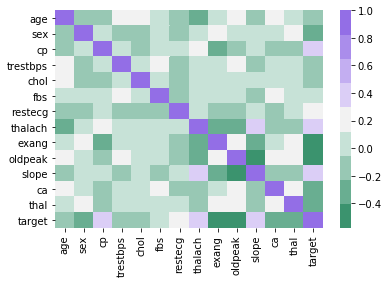

In [6]:
_ = data.corr()
sns.heatmap(_, cmap=sns.diverging_palette(150, 275, s=80, l=55, n=9))
#Not the prettiest plot but I'm using a diverging colour pallette so 
#that its easier to pick out the values closest to 0 around the target

# Second Step: model selection

Because the dataset is this small I'll be experimenting with model complexity before feature selection/importance. Avoiding overfitting will be the main hurdle for this task.

In [7]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score
X = data.drop(['target'], axis=1)
y = data['target']

In [8]:
train_X, val_X, train_y, val_y = train_test_split(X, y, random_state = 1, test_size=.2)

In [9]:
from sklearn.ensemble import GradientBoostingRegressor

est_range = range(5, 105, 5)
score_graph = {'ROC AUC Score': [], 'n_estimators': []}
est_list = []
score_list = []
for num in est_range:
    gbr = GradientBoostingRegressor(n_estimators=num, random_state=0)
    gbr.fit(train_X, train_y)
    ls_preds = gbr.predict(val_X)
    acc = roc_auc_score(val_y, ls_preds)
    print('ROC AUC Score with',num ,'estimators is: ', acc)
    score_graph['ROC AUC Score'] = score_graph['ROC AUC Score'] + [acc]
    score_graph['n_estimators'] = score_graph['n_estimators'] + [num]

ROC AUC Score with 5 estimators is:  0.7951612903225806
ROC AUC Score with 10 estimators is:  0.8096774193548387
ROC AUC Score with 15 estimators is:  0.8295698924731183
ROC AUC Score with 20 estimators is:  0.8247311827956989
ROC AUC Score with 25 estimators is:  0.8311827956989247
ROC AUC Score with 30 estimators is:  0.8376344086021505
ROC AUC Score with 35 estimators is:  0.8419354838709677
ROC AUC Score with 40 estimators is:  0.8419354838709677
ROC AUC Score with 45 estimators is:  0.843010752688172
ROC AUC Score with 50 estimators is:  0.8408602150537634
ROC AUC Score with 55 estimators is:  0.8440860215053764
ROC AUC Score with 60 estimators is:  0.8419354838709678
ROC AUC Score with 65 estimators is:  0.8376344086021505
ROC AUC Score with 70 estimators is:  0.8419354838709677
ROC AUC Score with 75 estimators is:  0.8376344086021505
ROC AUC Score with 80 estimators is:  0.8408602150537634
ROC AUC Score with 85 estimators is:  0.8397849462365592
ROC AUC Score with 90 estimators 

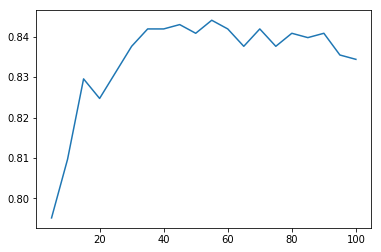

In [10]:
sns.lineplot(x=score_graph['n_estimators'], y=score_graph['ROC AUC Score'])

# When selecting an optimal parameter where there is a plateau
# I tend to pick the side of the plateau that has the lowest complexity.
# This helps prevent overfitting



# Step Three: feature importance

Working backwards from a sufficient model now we will use Permutation Importance to determine which features are adding signal and which are adding noise.

In [11]:
import warnings
warnings.filterwarnings("ignore")

In [12]:
import eli5
from eli5.sklearn import PermutationImportance

my_model = GradientBoostingRegressor(n_estimators=35).fit(train_X, train_y)

perm = PermutationImportance(my_model, random_state=1).fit(val_X, val_y)
eli5.show_weights(perm, feature_names = val_X.columns.tolist())

Using TensorFlow backend.


Weight,Feature
0.1076 ± 0.0413,ca
0.0838 ± 0.0530,oldpeak
0.0701 ± 0.0350,thal
0.0243 ± 0.0221,age
0.0209 ± 0.0517,cp
0.0205 ± 0.0171,slope
0.0128 ± 0.0407,sex
0.0062 ± 0.0376,chol
0.0004 ± 0.0465,thalach
-0.0011 ± 0.0111,restecg


As we can see above there are three strong features (ca, oldpeak, and thal). Slope, age, and sex have some relevence as well but not a high enough relevence to confirm that it isn't due to random chance.

Permeation importance works by shuffling the data in a single column, then rerunning the model and evaluating its performance. a higher number indicates a larger positive impact to the model by leaving the datapoint intact. A negative permeation importance means that the model actually improved as a result of the shuffle (so random chance was a better predictor than the original datapoint). If we look at the largest negative of the set, 'exang', its value is -0.03, so that is where I'm drawing my line of feature value.

In [13]:
feat = ['ca', 'oldpeak', 'thal']
X = data[feat]
y = data['target']
train_X, val_X, train_y, val_y = train_test_split(X, y, random_state = 1, test_size=.2)

In [14]:
gbr = GradientBoostingRegressor(n_estimators=35, random_state=0)
gbr.fit(train_X, train_y)
ls_preds = gbr.predict(val_X)
print('ROC AUC Scoree is: ', roc_auc_score(val_y, ls_preds))

ROC AUC Scoree is:  0.9102150537634409


As a side note: at this point since we are using fewer features we also need to prune the complexity of the model to prevent overfitting.

ROC AUC Score with 5 estimators is:  0.9204301075268817
ROC AUC Score with 10 estimators is:  0.9193548387096774
ROC AUC Score with 15 estimators is:  0.9048387096774193
ROC AUC Score with 20 estimators is:  0.906989247311828
ROC AUC Score with 25 estimators is:  0.9102150537634408
ROC AUC Score with 30 estimators is:  0.9102150537634408
ROC AUC Score with 35 estimators is:  0.9102150537634409
ROC AUC Score with 40 estimators is:  0.9091397849462366
ROC AUC Score with 45 estimators is:  0.906989247311828
ROC AUC Score with 50 estimators is:  0.9091397849462366
ROC AUC Score with 55 estimators is:  0.9102150537634408
ROC AUC Score with 60 estimators is:  0.9123655913978495
ROC AUC Score with 65 estimators is:  0.9134408602150537
ROC AUC Score with 70 estimators is:  0.9123655913978493
ROC AUC Score with 75 estimators is:  0.9123655913978493
ROC AUC Score with 80 estimators is:  0.914516129032258
ROC AUC Score with 85 estimators is:  0.914516129032258
ROC AUC Score with 90 estimators is:

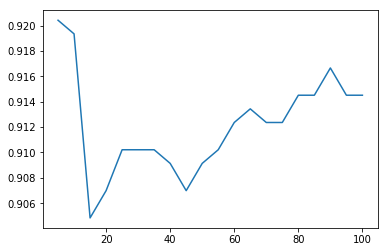

In [15]:
est_range = range(5, 105, 5)
score_graph = {'ROC AUC Score': [], 'n_estimators': []}
est_list = []
score_list = []
# A coder with some forsight might have just created a function for this instead of copy pasting my prior code
for num in est_range:
    gbr = GradientBoostingRegressor(n_estimators=num, random_state=0)
    gbr.fit(train_X, train_y)
    ls_preds = gbr.predict(val_X)
    acc = roc_auc_score(val_y, ls_preds)
    print('ROC AUC Score with',num ,'estimators is: ', acc)
    score_graph['ROC AUC Score'] = score_graph['ROC AUC Score'] + [acc]
    score_graph['n_estimators'] = score_graph['n_estimators'] + [num]
sns.lineplot(x=score_graph['n_estimators'], y=score_graph['ROC AUC Score'])

In [16]:
gbr = GradientBoostingRegressor(n_estimators=5, random_state=0)
gbr.fit(train_X, train_y)
ls_preds = gbr.predict(val_X)
print('ROC AUC Scoree is: ', roc_auc_score(val_y, ls_preds))

ROC AUC Scoree is:  0.9204301075268817


# Step 5: Classification thresholds

Up to this point we've been using the area under curve for assessing the probabilities that the model assessed to each individual. Now to change tracks to predict which patients will have heart disease. This time I'm going to loop through and see how high we can set the threshold before we start seeing false negatives (where someone with heart disease would be told they are fine).

While not strictly speaking the goal of the initial task, one of the metrics that matters most to me is if the model would tell someone they are fine, only to have a heart attack occur (basically I'm looking for an accurate yet pessimistic model) 

In [17]:
from sklearn.metrics import confusion_matrix

def rounder(num, thresh=0.5):
    if num >= thresh:
        return 1
    else:
        return 0

In [18]:
rounding = pd.Series([rounder(x,.2) for x in ls_preds])
confuse = confusion_matrix(val_y, rounding)
print(confuse[[1],[0]])

[0]


Accuracy with threshold set to 0.1 is:  0.5081967213114754
Accuracy with threshold set to 0.2 is:  0.5081967213114754
Accuracy with threshold set to 0.3 is:  0.5081967213114754
Accuracy with threshold set to 0.4 is:  0.7213114754098361
Accuracy with threshold set to 0.5 is:  0.8852459016393442
Accuracy with threshold set to 0.6 is:  0.819672131147541
Accuracy with threshold set to 0.7 is:  0.7868852459016393
Accuracy with threshold set to 0.8 is:  0.4918032786885246
Accuracy with threshold set to 0.9 is:  0.4918032786885246


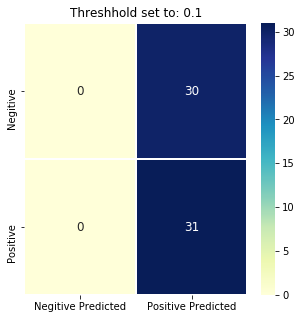

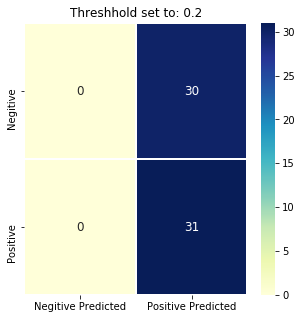

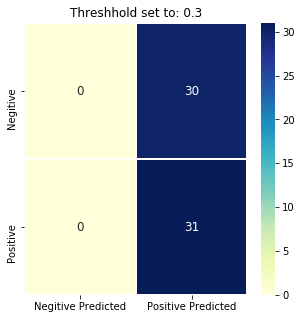

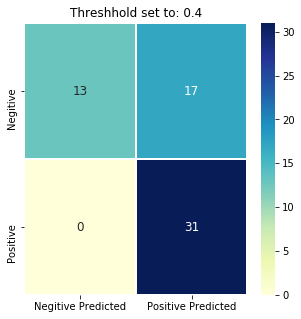

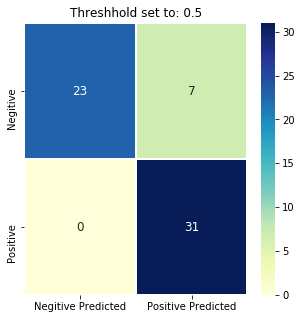

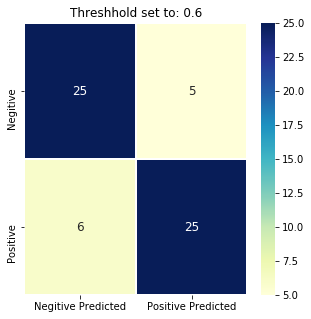

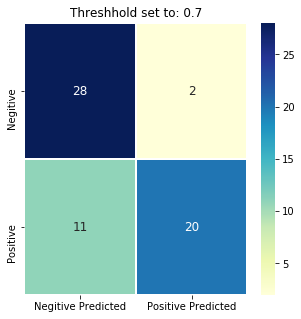

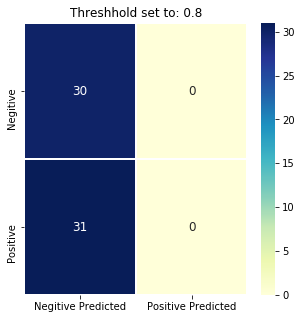

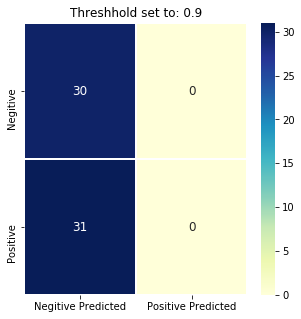

In [19]:
import matplotlib
from matplotlib.pyplot import figure
false_negitives = []
threshholds = []
for num in range(1, 10, 1):
    n = num/10
    rounding = pd.Series([rounder(x,n) for x in ls_preds])
    print('Accuracy with threshold set to',n ,'is: ', accuracy_score(val_y, rounding))
    confuse = confusion_matrix(val_y, rounding)
    false_negitives = false_negitives + [int(confuse[[1],[0]])]
    threshholds = threshholds + [n]
    confuse = pd.DataFrame(confuse)
    figure(num=None, figsize=(5, 5))
    sns.heatmap(confuse, linewidths=1,annot=True, fmt='.5g', annot_kws={"size": 12},cmap="YlGnBu", 
                yticklabels=['Negitive', 'Positive'], xticklabels=['Negitive Predicted', 'Positive Predicted']).set_title('Threshhold set to: '+str(n))

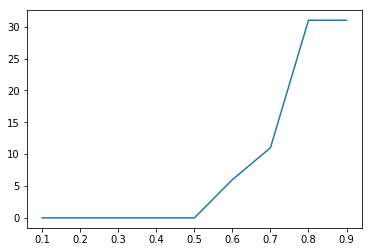

In [20]:
# this plots the rate of false negitives as we increase the 
# threshholds for when a person is determined to have heart deasease 
sns.lineplot(y=false_negitives, x=threshholds)

# Final Thoughts:

With the threshold for predicting heart disease set to .5 (so the model initially predicted a 50% chance or greater to produce a positive outcome) we have 0 false positive cases and an accuracy of 88%. It's not perfect, but I'm absolutely satisfied with those results.

I would have liked to get a more accurate model, but due to the limited number of cases I probably was overly cautious of overfitting. I also probably could have used grid search to squeeze a bit more performance out of the model. Furthermore, the data that's needed to supply this model, and effort needed to prepare the data, almost makes it easier just to have a physician evaluate the patient. The original data set has a few more features in it, and I wonder if it would have been worth while to source the added data or if it would have symply created too much noise.

As one other side note, many of the techniques I chose to use in this notebook scale poorly. So having a small dataset to start with isn't always a bad thing. Alternatively, some of the loops I used could be used on a subset of a larger dataset.

This year I've challenged myself to complete one task on Kaggle per week, in order to develop a larger Data Science portfolio. If you found this notebook useful or interesting please give it an upvote. I'm always open to constructive feedback. If you have any questions, comments, concerns, or if you would like to collaborate on a future task of the week feel free to leave a comment here or message me directly.
